# Ordinal Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from py_utils import math

In [2]:
# Generate random data to model
np.random.seed(1)
n, n_class, n_var = 10000, 5, 4
#n, n_class, n_var = 10000, 4, 5

X = np.random.randn(n, n_var)

b_act = np.random.randn(n_var)
#b_out = np.sort(np.random.randn(n_class-1))
b_out = np.linspace(-2, 2, n_class-1)
y_logit = np.dot(X, b_act)[:, np.newaxis]
p = y_logit + np.tile(b_out, (n, 1))
p = math.sigmoid(p)
p = np.hstack((np.zeros((n, 1)), p, np.ones((n, 1))))
p = np.diff(p, axis=1)

y_vals = np.arange(1, n_class + 1)
assert len(y_vals) == p.shape[1]

y = np.array([np.random.choice(y_vals, size=1, p=p[i])[0] for i in range(n)])

X.shape, y.shape

((10000, 4), (10000,))

In [3]:
b_out

array([-2.        , -0.66666667,  0.66666667,  2.        ])

In [4]:
pd.Series(y).value_counts()

1    3011
5    2837
3    1447
4    1372
2    1333
dtype: int64

In [5]:
from ml.scipy import optimize, models
param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()
#constraints.add_gtez('X0')
# constraints.add_gte('X1', 'X8')
# constraints.add_gte('X2', 'X9')
# constraints.add_gte('X3', 'X10')
# constraints.add_gte('X4', 'X11')
# constraints.add_gte('X5', 'X12')
# constraints.add_gte('X6', 'X13')
#constraints.add_gtev('X1', 5.0)

model = (
    models.ScipyOrdinalRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_outcome_intercepts(n_class)
    .build()
)


In [6]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, check_gradient=True)
est.fit(X, y)

CPU times: user 32.3 s, sys: 601 ms, total: 32.9 s
Wall time: 19.2 s


In [7]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 21
    Number of function evaluations: 24
    Objective Function Value: 0.9745157498875303
    


In [8]:
est.get_gradient_comparison()

,error,parameters
0,4.395770e-08,"[0.0682105772189, -0.179323626614, 0.222350392..."
1,1.085764e-07,"[0.116390509719, -0.302561345192, 0.3771157765..."
2,6.109178e-08,"[0.162156986503, -0.419739550111, 0.5255665018..."
3,3.114654e-08,"[0.398862138577, -1.03723819432, 1.31249250401..."
4,1.437393e-08,"[0.488369572228, -1.27884098599, 1.62801451097..."
5,1.944122e-08,"[0.572494240522, -1.51215891104, 1.93756522844..."
6,4.727905e-08,"[0.630375826347, -1.67807603041, 2.16173351131..."
7,2.275784e-08,"[0.683259896001, -1.83593225387, 2.37967927175..."
8,2.832861e-08,"[0.714195546208, -1.93621108377, 2.52406557117..."
9,3.003764e-08,"[0.709171247306, -1.93205022401, 2.52692206222..."


In [75]:
est.get_gradient_comparison()

,error,parameters
0,1.284255e-06,"[0.0682105772189, -0.179323626614, 0.222350392..."
1,3.581825e-07,"[0.116390509719, -0.302561345192, 0.3771157765..."
2,7.312830e-07,"[0.162156986503, -0.419739550111, 0.5255665018..."
3,3.659264e-07,"[0.398862138577, -1.03723819432, 1.31249250401..."
4,2.775195e-07,"[0.488369572228, -1.27884098599, 1.62801451097..."
5,6.350871e-07,"[0.572494240522, -1.51215891104, 1.93756522844..."
6,5.330318e-07,"[0.630375826347, -1.67807603041, 2.16173351131..."
7,9.931508e-07,"[0.683259896001, -1.83593225387, 2.37967927175..."
8,4.860502e-07,"[0.714195546208, -1.93621108377, 2.52406557117..."
9,4.599654e-07,"[0.709171247306, -1.93205022401, 2.52692206222..."


In [9]:
est.fit_

     fun: 0.9745157498875303
     jac: array([ -1.06188969e-04,   6.54336690e-05,   4.29177837e-05,
        -1.68795692e-06,   4.59328135e-05,   3.53401889e-05,
         7.62154584e-05,   3.49002720e-04])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 0.67424014, -1.79497158,  2.31726527,  1.31418292, -2.02124262,
       -0.67701529,  0.68733554,  2.07735594])

In [10]:
d_inf = est.inference()
d_inf

{'intercepts': OrderedDict([('Outcome:1', -2.0212426226703957), ('Outcome:2', -0.67701529378108161), ('Outcome:3', 0.68733553909795453), ('Outcome:4', 2.0773559405486695)]), 'linear': OrderedDict([('X0', 0.6742401439198209), ('X1', -1.7949715836039617), ('X2', 2.317265267124466), ('X3', 1.3141829226090704)]), 'fit': OrderedDict()}

In [11]:
b_act

array([ 0.65018006, -1.76494683,  2.29100388,  1.3242936 ])

In [12]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

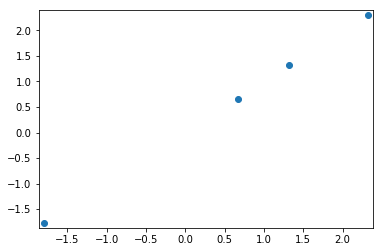

In [80]:
compare(pd.Series(d_inf['linear']), b_act)

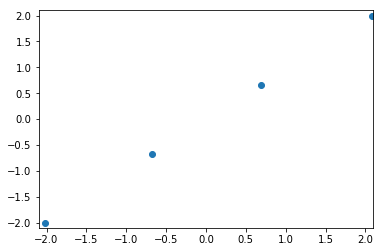

In [81]:
compare(pd.Series(d_inf['intercepts']), b_out)

In [14]:
d_proba = est.predict(X, key='probabilities')
d_proba[:5]

array([[  7.85690860e-02,   1.67864958e-01,   3.14912485e-01,
          2.75731931e-01,   1.62921539e-01],
       [  9.96783607e-01,   2.37574848e-03,   6.25686378e-04,
          1.61409988e-04,   5.35483698e-05],
       [  3.36745636e-01,   3.23950195e-01,   2.23291922e-01,
          8.43595623e-02,   3.16526849e-02],
       [  4.09150962e-01,   3.17312100e-01,   1.85761286e-01,
          6.43706489e-02,   2.34050036e-02],
       [  5.74925623e-01,   2.63451707e-01,   1.14671351e-01,
          3.48297724e-02,   1.21215466e-02]])

In [15]:
pd.Series(np.argmax(d_proba, axis=1)).value_counts()

0    3586
4    3301
2    1594
3     865
1     654
dtype: int64

In [16]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5
predicted,,,,,
1,2591,587,288,89,31
2,169,215,166,80,24
3,185,332,520,360,197
4,35,106,233,270,221
5,31,93,240,573,2364


In [86]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
pd.DataFrame({
    'predicted': GradientBoostingClassifier().fit(X, y).predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5
predicted,,,,,
1,2706,542,302,112,39
2,106,421,134,102,35
3,102,169,559,157,130
4,55,82,165,475,125
5,42,119,287,526,2508
